In [1]:
import collections
import math

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

sns.set(style='dark', font_scale=1.5, palette='colorblind')

## Data

### GDP

In [2]:
countries = ['france', 'germany', 'greece', 'italy', 'portugal', 'spain']
iso_countries = ['FR', 'DE', 'EL', 'IT', 'PT', 'ES']
country_names = {
    country: country.title()
    for country in countries
}

data = {}
for country in countries:
    path = './data/gdp/{}.csv'.format(country)
    df = pd.read_csv(path, parse_dates=['DATE'])
    df.columns = ['date', 'gdp']
    data[country] = df


### Population

In [3]:
population_df = pd.read_csv('data/population.csv', parse_dates=['Year'])
population_df.columns = ['country_name', 'country_code', 'year', 'population']

population = population_df[population_df['country_name'].isin(set(country_names.values()))]

In [4]:
min_country_years = {}
max_country_years = {}
for country in countries:
    min_country_years[country] = (
        population[
            population_df['country_name'] == country_names[country]
        ].groupby('country_name').min()['year'].iloc[0]
    ).year
    max_country_years[country] = (
        population[
            population_df['country_name'] == country_names[country]
        ].groupby('country_name').max()['year'].iloc[0]
    ).year

def get_population(country, row):
    country_name = country_names[country]
    
    min_country_year = min_country_years[country]
    max_country_year = max_country_years[country]

    year = row.date.year
    if year < min_country_year:
        year = min_country_year
    elif year > max_country_year:
        year = max_country_year

    year_ts = pd.Timestamp(year, 1, 1)
    return population[
        (population['country_name'] == country_name) &
        (population['year'] == year_ts)
    ]['population'].iloc[0]

for country in countries:
    df = data[country]
    df['population'] = df.apply(lambda row: get_population(country, row), axis=1)

/Users/srom/workspace/ds/env/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/srom/workspace/ds/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [5]:
for country in countries:
    df = data[country]
    df['gdp_prev'] = df.shift()['gdp']
    df['gdp_yoy'] = df.apply(lambda r: 100 * (r['gdp'] - r['gdp_prev']) / r['gdp_prev'], axis=1)

In [6]:
data['greece'].head()

,date,gdp,population,gdp_prev,gdp_yoy
0,1995-01-01,39193.1,10562153.0,NaN,NaN
1,1995-04-01,39577.6,10562153.0,39193.1,0.981040
2,1995-07-01,39799.0,10562153.0,39577.6,0.559407
3,1995-10-01,40026.9,10562153.0,39799.0,0.572627
4,1996-01-01,40234.9,10608800.0,40026.9,0.519651


### Unemployment

In [7]:
unemp_raw = pd.read_csv('data/unemployment.tsv', sep='\t')
unemp_raw.columns = ['raw_header'] + [c.strip() for c in list(unemp_raw.columns)[1:]]

def get_part_of_column(row, index):
    return list(str(row['raw_header']).split(','))[index]

unemp_raw['age_group'] = unemp_raw.apply(lambda x: get_part_of_column(x, 1), axis=1)
unemp_raw['country_iso'] = unemp_raw.apply(lambda x: get_part_of_column(x, 3), axis=1)
unemp_raw.replace(' d', '', inplace=True, regex=True)
unemp_raw.replace(':', '', inplace=True, regex=True)
unemp_raw[unemp_raw.columns[1:-3]] = unemp_raw[unemp_raw.columns[1:-3]].apply(pd.to_numeric, errors='coerce')

unemployment__ = unemp_raw[unemp_raw['country_iso'].isin(iso_countries)]
unemployment__['country'] = unemployment__['country_iso'].apply(lambda c: countries[iso_countries.index(c)])

unemployment = unemployment__[unemployment__['age_group'] == 'TOTAL'].reset_index()
unemployment_youth = unemployment__[unemployment__['age_group'] == 'Y_LT25'].reset_index()

/Users/srom/workspace/ds/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
unemployment_youth.head()

,index,raw_header,1995,1996,1997,1998,1999,2000,2001,2002,...,2011,2012,2013,2014,2015,2016,2017,age_group,country_iso,country
0,61,"T,Y_LT25,PC_ACT,DE",8.9,10.0,10.6,9.7,9.0,8.7,8.3,9.8,...,8.5,8.0,7.8,7.7,7.2,7.1,6.8,Y_LT25,DE,germany
1,64,"T,Y_LT25,PC_ACT,EL",NaN,NaN,NaN,30.4,31.5,29.1,28.0,26.8,...,44.7,55.3,58.3,52.4,49.8,47.3,43.6,Y_LT25,EL,greece
2,65,"T,Y_LT25,PC_ACT,ES",39.8,39.2,36.1,32.4,26.4,23.2,21.1,22.2,...,46.2,52.9,55.5,53.2,48.3,44.4,38.6,Y_LT25,ES,spain
3,67,"T,Y_LT25,PC_ACT,FR",34.7,37.2,39.3,37.8,37.3,31.5,29.1,30.5,...,22.6,24.4,24.9,24.2,24.7,24.6,22.3,Y_LT25,FR,france
4,71,"T,Y_LT25,PC_ACT,IT",29.9,29.9,29.6,29.2,28.0,26.2,23.1,22.0,...,29.2,35.3,40.0,42.7,40.3,37.8,34.7,Y_LT25,IT,italy


In [9]:
unemployment.head()

,index,raw_header,1995,1996,1997,1998,1999,2000,2001,2002,...,2011,2012,2013,2014,2015,2016,2017,age_group,country_iso,country
0,5,"T,TOTAL,PC_ACT,DE",8.2,8.9,9.6,9.4,8.6,7.9,7.8,8.6,...,5.8,5.4,5.2,5.0,4.6,4.1,3.8,TOTAL,DE,germany
1,8,"T,TOTAL,PC_ACT,EL",NaN,NaN,NaN,11.1,12.0,11.2,10.7,10.3,...,17.9,24.5,27.5,26.5,24.9,23.6,21.5,TOTAL,EL,greece
2,9,"T,TOTAL,PC_ACT,ES",20.7,19.9,18.4,16.4,13.6,11.9,10.6,11.5,...,21.4,24.8,26.1,24.5,22.1,19.6,17.2,TOTAL,ES,spain
3,11,"T,TOTAL,PC_ACT,FR",10.2,10.5,10.7,10.3,10.0,8.6,7.8,7.9,...,9.2,9.8,10.3,10.3,10.4,10.1,9.4,TOTAL,FR,france
4,15,"T,TOTAL,PC_ACT,IT",11.2,11.2,11.2,11.3,10.9,10.0,9.0,8.5,...,8.4,10.7,12.1,12.7,11.9,11.7,11.2,TOTAL,IT,italy


### Colors

In [10]:
palette = sns.color_palette(n_colors=len(countries))
colors = {
    country: palette[i]
    for i, country in enumerate(countries)
}

## Growth Domestic Product

In [11]:
def plot_gdp(data, countries):
    f, ax = plt.subplots(1, figsize=(20, 8))
    
    dates = sorted({row.date for row in data['greece'].itertuples()})
    
    ax.set_title('Real Gross Domestic Product (Billions of chained 2010 Euros)')
    
    for country in countries:
        df = data[country]
        gdp = df[df.date.isin(dates)]['gdp'] / 1e3

        ax.plot(dates, gdp, label=country, color=colors[country])

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    ax.legend()
    ax.grid(True)

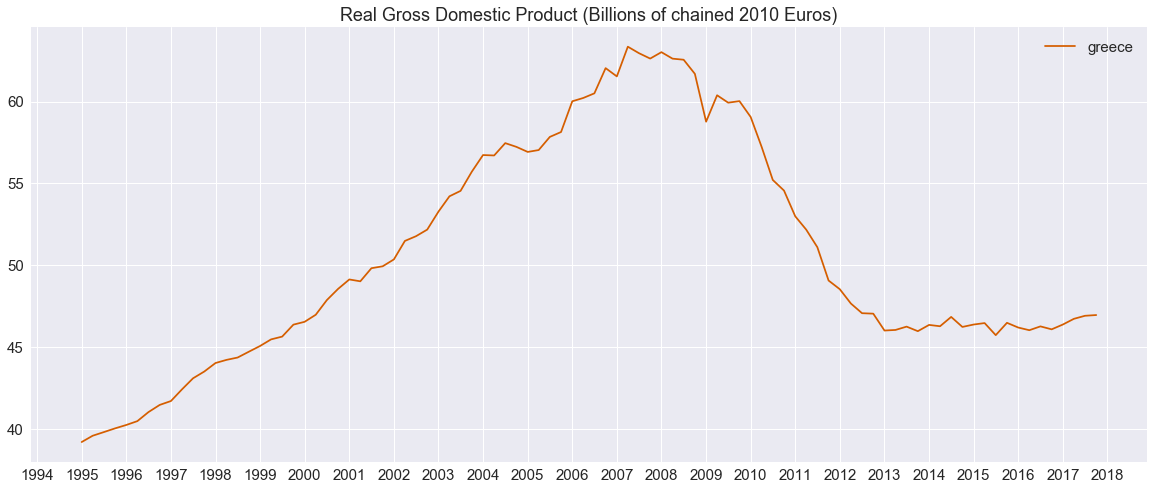

In [12]:
plot_gdp(data, ['greece'])

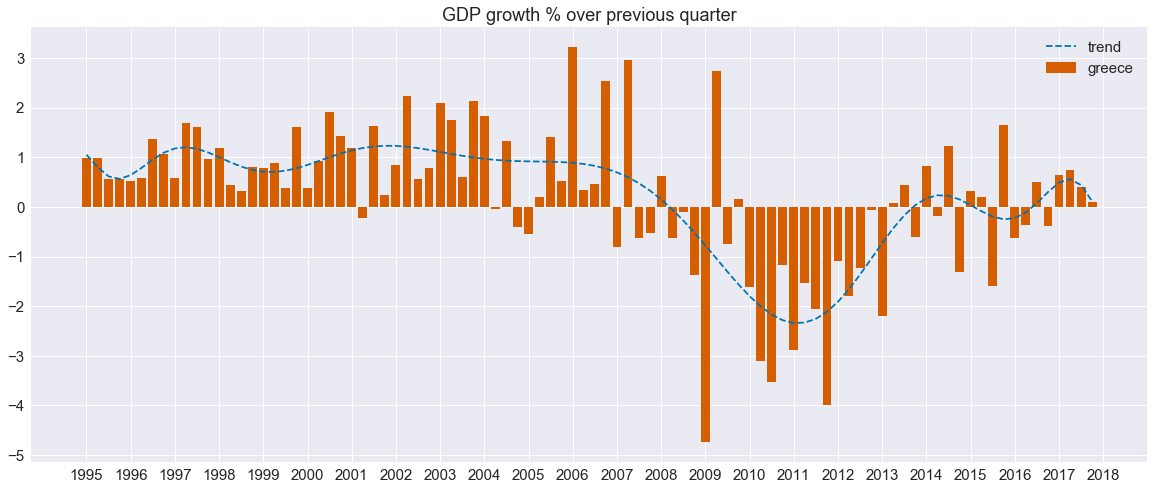

In [13]:
def plot_gdp_yoy(data, country):
    f, ax = plt.subplots(1, figsize=(20, 8))

    ax.set_title('GDP growth % over previous quarter')

    dates = sorted({row.date for row in data['greece'].itertuples()})

    #ax.plot(dates, [0] * len(dates), linewidth=2, color='grey', linestyle='--')

    df = data[country]
    gdp_yoy = df[df.date.isin(dates)]['gdp_yoy']
    
    x = list(range(0, len(dates)))
    y = gdp_yoy.tolist()
    y[0] = y[1]
    
    z = np.polyfit(x, y, 15)
    p = np.poly1d(z)
    trend = [p(i) for i in x]
    
    ax.bar(x, y, label=country, color=colors[country], alpha=1)
    ax.plot(x, trend, label='trend', linestyle='--')
    
    xticks = [index for index, date in enumerate(dates) if date.month == 1 and date.day == 1] + [len(dates)]
    ax.set_xticks(xticks)
    xlabels = [
        date.year
        for date in dates
        if date.month == 1 and date.day == 1
    ]
    xlabels += ['2018']
    ax.set_xticklabels(xlabels)

    ax.legend()
    ax.grid(True)

plot_gdp_yoy(data, 'greece')

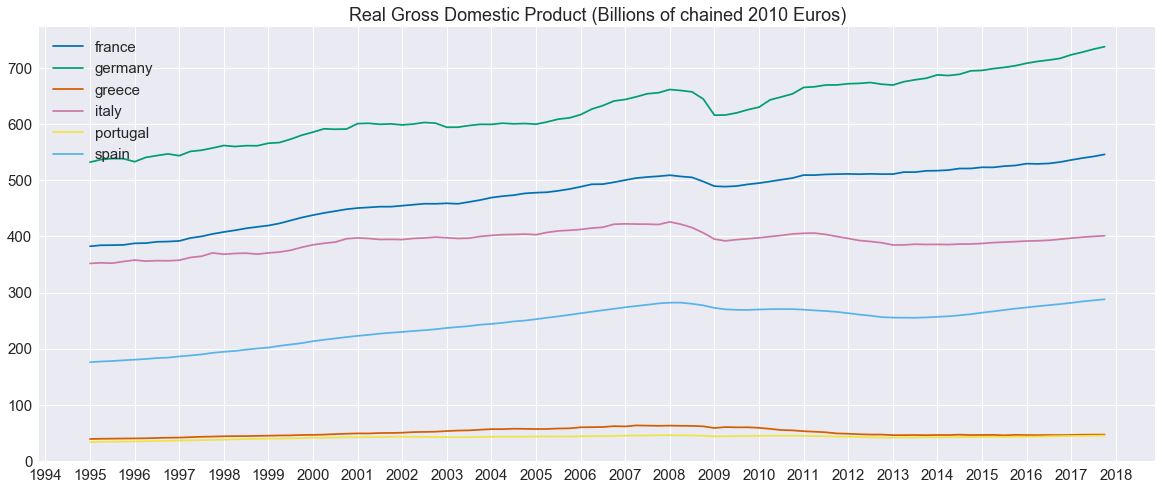

In [14]:
plot_gdp(data, countries)

## % of 2000 GDP

In [15]:
for country in countries:
    df = data[country]
    gdp_2000 = df[df.date == pd.Timestamp(2000, 1, 1)]['gdp']
    df['gdp_growth'] = df.apply(lambda x: 100 * (x['gdp'] - gdp_2000) / gdp_2000, axis=1)

In [16]:
data['france'].head()

,date,gdp,population,gdp_prev,gdp_yoy,gdp_growth
0,1975-01-01,237727.0,54252574.0,NaN,NaN,-45.703727
1,1975-04-01,237076.0,54252574.0,237727.0,-0.273844,-45.852414
2,1975-07-01,237162.0,54252574.0,237076.0,0.036275,-45.832772
3,1975-10-01,242059.0,54252574.0,237162.0,2.064833,-44.714309
4,1976-01-01,244436.0,54541493.0,242059.0,0.981992,-44.171408


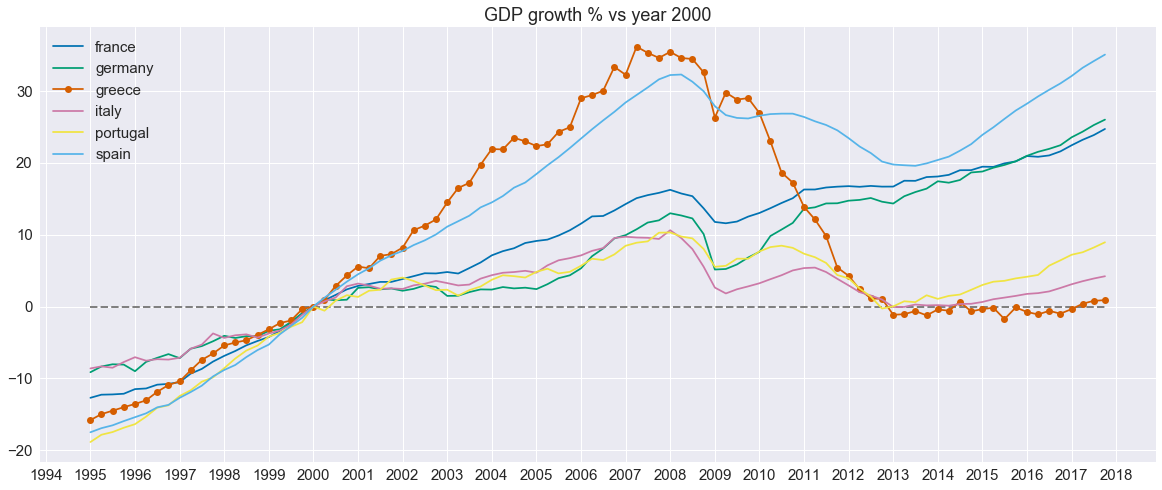

In [17]:
def plot_gdp_growth_versus_2000():
    f, ax = plt.subplots(1, figsize=(20, 8))

    ax.set_title('GDP growth % vs year 2000')

    dates = sorted({row.date for row in data['greece'].itertuples()})

    ax.plot(dates, [0] * len(dates), linewidth=2, color='grey', linestyle='--')

    for country in countries:
        df = data[country]
        gdp = df[df.date.isin(dates)]['gdp_growth']
        if country == 'greece':
            marker='o'
        else:
            marker = None
        ax.plot(dates, gdp, label=country, color=colors[country], marker=marker)

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.legend()
    ax.grid(True)

plot_gdp_growth_versus_2000()

In [18]:
def plot_population(country):
    f, ax = plt.subplots(1, figsize=(20, 8))

    ax.set_title('Population (Millions)')

    df = population[(population['country_name'] == country_names[country]) & (population['year'] >= '1996-01-01')]
    dates = df['year']
    population_y = df['population'] / 1e6

    ax.plot(dates, population_y, label=country, color=colors[country])

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.legend()
    ax.grid(True)

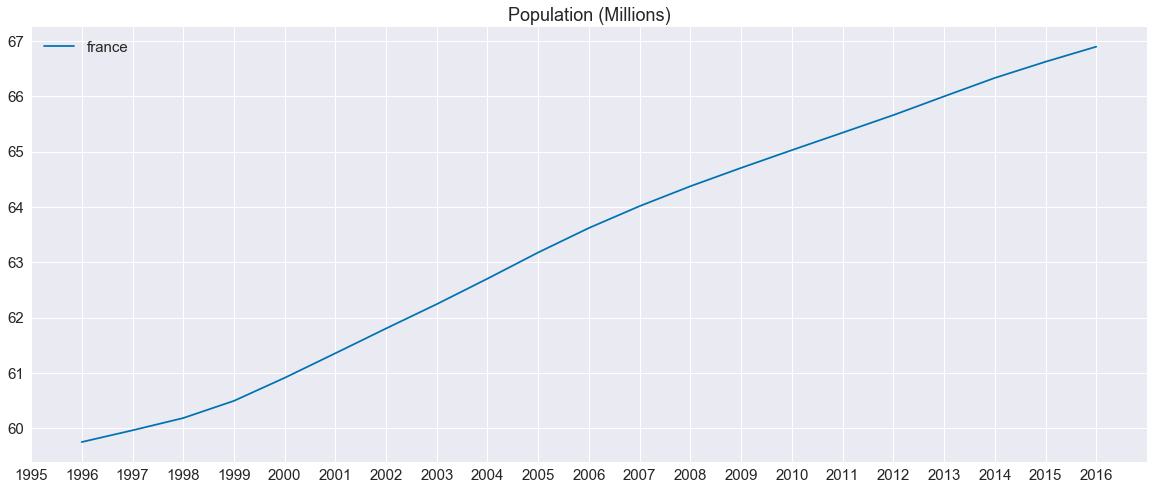

In [19]:
plot_population('france')

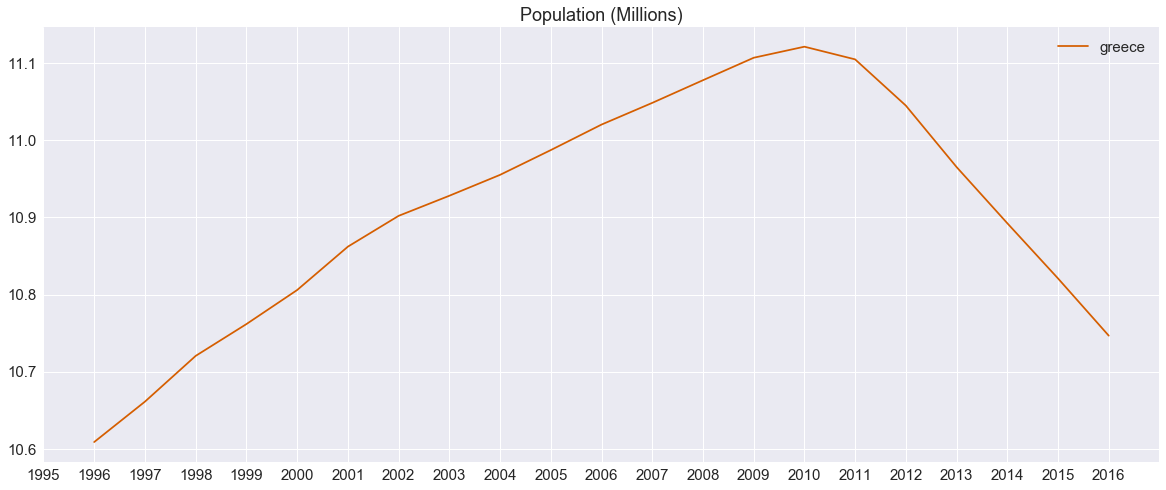

In [20]:
plot_population('greece')

In [21]:
for country in countries:
    df = data[country]
    population_2000 = df[df.date == pd.Timestamp(2000, 1, 1)]['population']
    df['population_growth'] = df.apply(lambda x: 100 * (x['population'] - population_2000) / population_2000, axis=1)

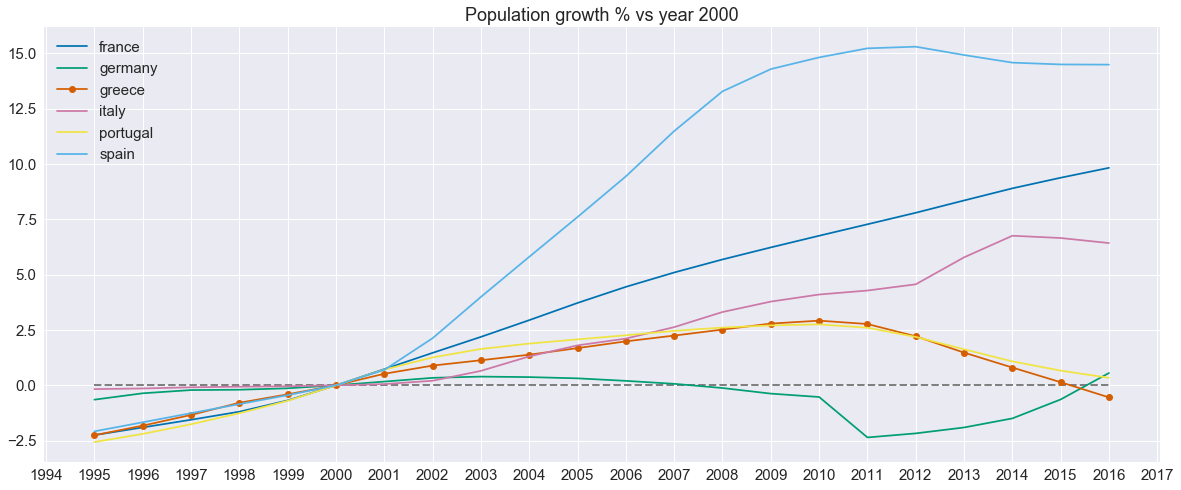

In [22]:
def plot_population_growth_versus_2000():
    f, ax = plt.subplots(1, figsize=(20, 8))

    ax.set_title('Population growth % vs year 2000')

    dates = sorted({
        row.date for row in data['greece'].itertuples()
        if row.date.month == 1 and row.date.day == 1 and row.date < pd.Timestamp(2017, 1, 1)
    })

    ax.plot(dates, [0] * len(dates), linewidth=2, color='grey', linestyle='--')

    for country in countries:
        df = data[country]
        gdp = df[df.date.isin(dates)]['population_growth']
        if country == 'greece':
            marker='o'
        else:
            marker = None
        ax.plot(dates, gdp, label=country, color=colors[country], marker=marker)

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.legend()
    ax.grid(True)

    
plot_population_growth_versus_2000()

## GDP per capita

In [23]:
for country in countries:
    df = data[country]
    df['gdp_per_capita'] = df.apply(lambda x: x['gdp'] * 1e6 / x['population'], axis=1)

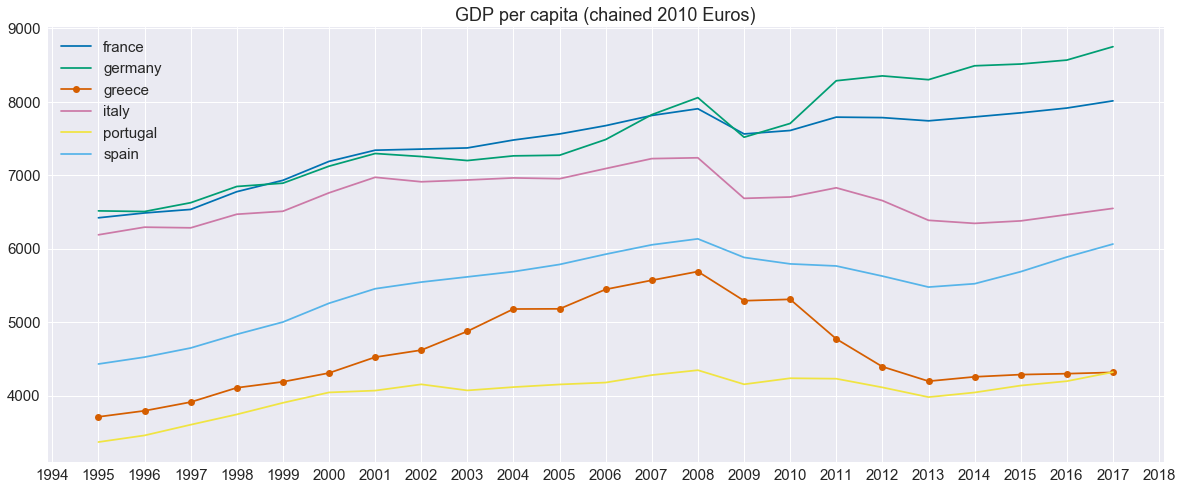

In [24]:
def plot_gdp_per_capita(data, countries):
    f, ax = plt.subplots(1, figsize=(20, 8))

    ax.set_title('GDP per capita (chained 2010 Euros)')

    dates = sorted({
        row.date for row in data['greece'].itertuples()
        if row.date.month == 1 and row.date.day == 1
    })

    for country in countries:
        df = data[country]
        gdp = df[df.date.isin(dates)]['gdp_per_capita']

        if country == 'greece':
            marker='o'
        else:
            marker = None

        ax.plot(dates, gdp, label=country, color=colors[country], marker=marker)

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.legend()
    ax.grid(True)


plot_gdp_per_capita(data, countries)

In [25]:
correlations = data['greece'].corr()

In [26]:
r2 = math.pow(correlations['gdp']['population'], 2)
round(r2 * 100, 2)

67.72

In [27]:
round(100 * 2 / 3, 2)

66.67

## Unemployment

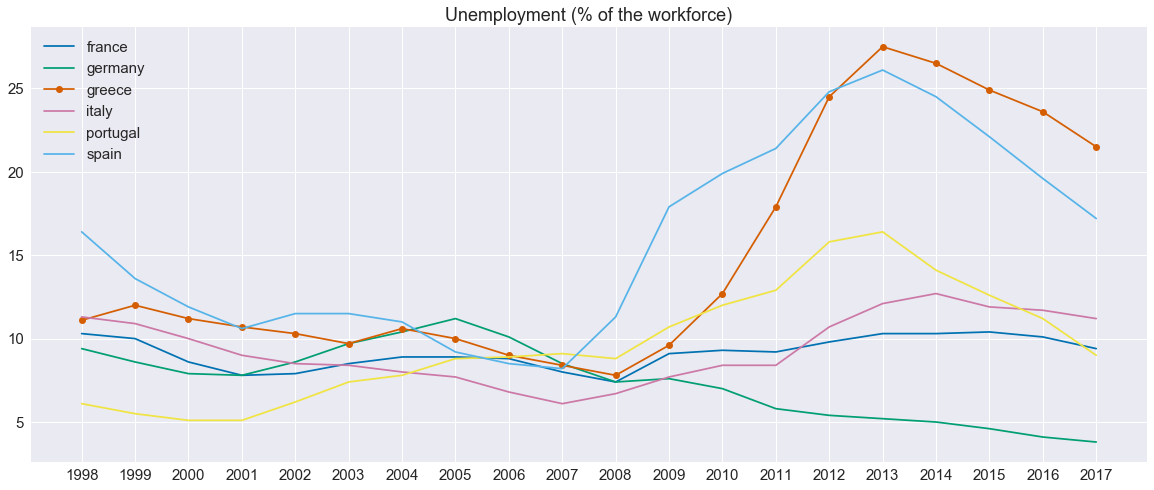

In [36]:
def plot_unemployment(data, countries, title='Unemployment (% of the workforce)'):
    f, ax = plt.subplots(1, figsize=(20, 8))

    ax.set_title(title)

    years = [str(y) for y in range(1998, 2018)]

    for country in countries:
        unemployment_series = data[
            data['country'] == country
        ].iloc[0][
            [c for c in data.columns if c in years]
        ]

        if country == 'greece':
            marker='o'
        else:
            marker = None

        ax.plot(years, unemployment_series, label=country, color=colors[country], marker=marker)

    ax.legend()
    ax.grid(True)
    

plot_unemployment(unemployment, countries)

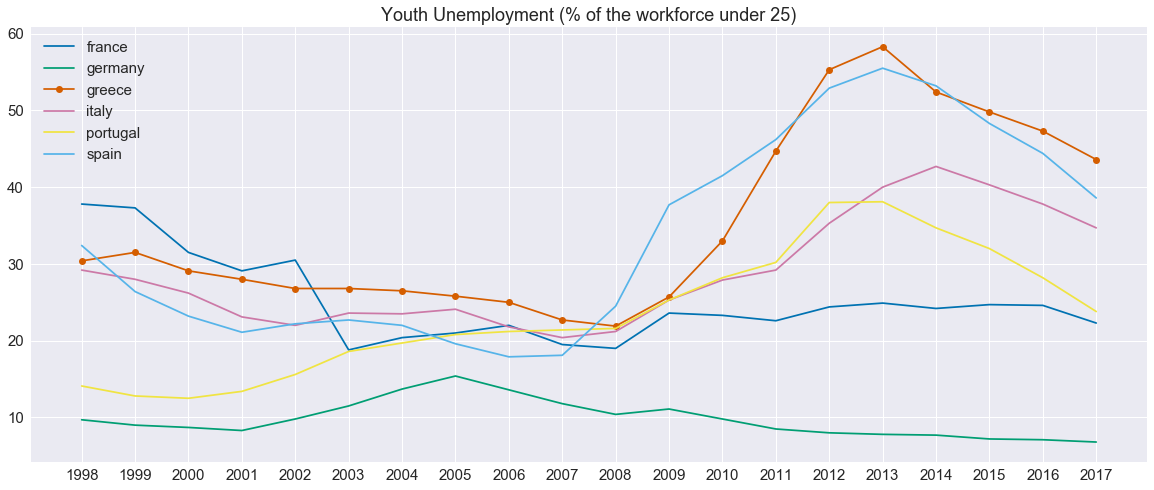

In [37]:
plot_unemployment(unemployment_youth, countries, title='Youth Unemployment (% of the workforce under 25)')